# Прогнозирование оттока пользователей телекоммуникационной                                                              компании

Ссылка на соревнование https://www.kaggle.com/c/telecom-clients-prediction2/overview

Данные для соревнования были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

Необходимо произвести оценку вероятности того, что клиент осуществит переход к конкуренту (churn prediction)

In [1]:
# Импортирую необходимые библиотеки
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', names = ['class'])
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


In [3]:
# В дальнейшем понадобится отдельно анализировать категориальные и числовые данные. Сделаю соответствуюшие списки.
numeric_features = data.columns[: 190]
categorical_features = data.columns[190 :]

Можно сразу заметить, что в данных много пропусков. Возможно, что некоторые признаки вовсе состоят из NaN. Посмотрю, что будет, если удалить строки/столбцы в которых есть пропуски

In [4]:
print('Первоначальная размерность', data.shape)
print('Размерность, если удалить строки, где есть хотя бы один пропуск', data.dropna(how='any', axis=0).shape)
print('Размерность, если удалить столбцы, где есть хотя бы один пропуск', data.dropna(how='any', axis=1).shape)

Первоначальная размерность (40000, 230)
Размерность, если удалить строки, где есть хотя бы один пропуск (0, 230)
Размерность, если удалить столбцы, где есть хотя бы один пропуск (40000, 19)


Если удалить столбцы/строки, в которых присутствуют пропуски, то мы теряем практически все данные.

In [5]:
# составим таблицу, в которой в 1-м столбце будет отображаться % пустых ячеек, во 2-м название признака.
na_frame = pd.DataFrame(round(data.isna().sum()/40000*100, 1))
na_frame.columns = ['percent']
na_frame['features'] = na_frame.index
na_frame.head()

,percent,features
Var1,98.6,Var1
Var2,97.5,Var2
Var3,97.5,Var3
Var4,96.8,Var4
Var5,97.1,Var5


In [6]:
# Посмотрим какое кол-во признаков содержит пропусков более 0,01%
empty_features = na_frame.loc[na_frame.percent >= 99.9, 'features'].values
print(len(empty_features))

18


Такие признаки не несут существенной информации, поэтому удалим их. 0.01% - это 40 значений от 40 000 всех строк.

In [7]:
# перед удалением обновим списки с названиями числовых/категориальных переменных
numeric_features = list(data[numeric_features].dropna(thresh=40, axis=1).columns)
categorical_features = list(data[categorical_features].dropna(thresh=40, axis=1).columns)

In [8]:
# удаляем эти столбцы
data.dropna(thresh=40, axis=1, inplace=True)
print('Размерность', data.shape)

Размерность (40000, 212)


Более внимательно посмотрим на числовые и категориальные признаки. Посмотрим какое количество уникальных значений содержит каждый признак.

In [9]:
cnt_numeric_features = pd.DataFrame(data[numeric_features].nunique())
cnt_numeric_features.columns = ['cnt']
cnt_numeric_features.sort_values(by=['cnt'], ascending=True).head()

,cnt
Var118,1
Var27,2
Var130,2
Var90,2
Var29,2


In [10]:
false_numeric_features = cnt_numeric_features.loc[cnt_numeric_features.cnt <= 10].index
print('Количество признаков с уникальными значениями меньше 10 = ', len(false_numeric_features))
false_numeric_features

Количество признаков с уникальными значениями меньше 10 =  37


Index(['Var2', 'Var4', 'Var7', 'Var11', 'Var19', 'Var26', 'Var27', 'Var29',
       'Var34', 'Var44', 'Var49', 'Var54', 'Var62', 'Var67', 'Var72', 'Var82',
       'Var87', 'Var90', 'Var93', 'Var97', 'Var100', 'Var110', 'Var116',
       'Var118', 'Var122', 'Var130', 'Var138', 'Var142', 'Var143', 'Var144',
       'Var146', 'Var147', 'Var155', 'Var159', 'Var161', 'Var173', 'Var181'],
      dtype='object')

37 из указанных по условиям задачи признаков содержит 10, либо меньшее количество уникальных значений. Есть признаки с 1 -2,... уникальным значением.

Это может говорить о ошибочности данных(но не обязательно), то есть возможно, некоторые категориальные признаки возможно ошибочно были отнесены к числовым. 

In [11]:
cnt_categorical_features = pd.DataFrame(data[categorical_features].nunique())
cnt_categorical_features.columns = ['cnt']
cnt_categorical_features.sort_values(by=['cnt'], ascending=False).head()

,cnt
Var214,13297
Var200,13297
Var217,12470
Var202,5542
Var199,4400


In [12]:
false_categorical_features = cnt_categorical_features.loc[cnt_categorical_features.cnt >=50].index
print('Количество признаков с уникальными значениями больше 50 = ', len(false_categorical_features))
false_categorical_features

Количество признаков с уникальными значениями больше 50 =  14


Index(['Var192', 'Var193', 'Var197', 'Var198', 'Var199', 'Var200', 'Var202',
       'Var204', 'Var212', 'Var214', 'Var216', 'Var217', 'Var220', 'Var222'],
      dtype='object')

В категориальных признаках обратная ситуация, есть признаки, в которых уникальных значений тысячи. У 14 признаков уникальных значений более 50.

Можно изменить озвученное в условиях задачи разделение признаков на категориальные и числовые. Составит различные варианты, обучить модель и сравнить качество.

При этом "ложные" числовые признаки мы можем отнести к категориальным. С категориальными же мы так поступить не можем, но можно попробовать обучить модель без этих признаков и сравнить метрики.

На этот случай сделаю соответствующие списки числовых и категориальных переменных.

In [13]:
# оставить только категориальные признаки с количеством уникальных значений < 50
categorical_features_1 = list(set(categorical_features) - set(false_categorical_features))
len(categorical_features_1)

24

In [14]:
# оставить категориальные признаки с количеством уникальных значений < 50, плюс "числовые" признаки с кол-муникальных значений 10 и меньше
categorical_features_2 = list(set(list(categorical_features) + list(false_numeric_features)) - set(false_categorical_features))
len(categorical_features_2)

61

In [15]:
# Числовые признаки с количеством уникальных значений > 10
numeric_features_2 = list(set(numeric_features) - set(false_numeric_features))
len(numeric_features_2)

137

Посмотрим на распределение классов

In [16]:
labels['class'].value_counts(normalize=True)

-1    0.9256
 1    0.0744
Name: class, dtype: float64

92.5% составляет класс "не отток". Выборка несбалансированная. 

Проверим, есть ли корреляция  переменных с целевой функцией.

Сначала проанализируем числовые признаки.

Целевая функция представляет собой бинарную переменную. Теоретически, это не помешает рассчитать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, однако анализировать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение.
В данном случае лучше рассчитать разность между мат ожиданием, посчитанному на объектах класса "1" и мат ожиданием, посчитанному на объектах класса "-1"


Для того, чтобы результаты были интерпретируемыми, сделаем сначала масштабирование числовых признаков.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[numeric_features])
scaled_data = scaler.transform(data[numeric_features])

In [18]:
# для удобства преобразую в DataFrame и объеденю с целевой меткой
scaled_frame = pd.DataFrame(scaled_data, columns=numeric_features)
scaled_all = pd.concat([scaled_frame, labels], axis = 1)
scaled_all.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var181,Var182,Var183,Var184,Var186,Var187,Var188,Var189,Var190,class
0,NaN,NaN,NaN,NaN,NaN,0.663655,NaN,NaN,NaN,NaN,...,-0.245018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,0.188927,0.033063,NaN,NaN,NaN,...,-0.245018,NaN,NaN,NaN,NaN,NaN,NaN,0.062436,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,0.242569,0.033063,NaN,NaN,NaN,...,-0.245018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,0.081644,0.033063,NaN,NaN,NaN,...,-0.245018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,-0.242887,0.033063,NaN,NaN,NaN,...,-0.245018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [19]:
# Создам фрейм, в котором будут столбцы: признак, корреляция, модуль корреляции. Отсортирую данные по уровню корреляции
correlation = []
for i in numeric_features:
    correlation.append(scaled_all[scaled_all['class'] == 1][i].mean() - scaled_all[scaled_all['class'] == -1][i].mean())
cor_frame = pd.DataFrame({'features':numeric_features, 'correlation':correlation})
cor_frame['abs'] = abs(cor_frame['correlation'])
cor_frame.sort_values(by=['abs'], ascending=False)

,features,correlation,abs
154,Var168,-0.563608,0.563608
171,Var188,0.481674,0.481674
172,Var189,-0.463551,0.463551
119,Var131,0.400726,0.400726
99,Var111,0.367104,0.367104
...,...,...,...
92,Var104,0.003095,0.003095
36,Var44,-0.001959,0.001959
117,Var129,0.001396,0.001396
111,Var123,-0.000431,0.000431


Можно сделать вывод о наличии у части числовых признаков корреляции с целевой переменной. Эти данные впоследствии можно использовать для отбора признаков - попробовать убрать из модели для обучения признаки с низкой корреляцией.

Теперь посмотрим на корреляцию категориальных переменных. Здесь подойдет корреляция Крамера

In [20]:
import scipy.stats as ss

def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [36]:
# Сначала пустые ячейки в категориальных признаках преобразуем в строку 'nan'
data[categorical_features] = data[categorical_features].fillna('nan')

In [37]:
features = []
cramers_cor = []
for column in data[categorical_features].columns:
    features.append(column)
    cramers_cor.append(cramers_stat(pd.crosstab(data[column], labels['class'])))
cramers_correlation = pd.DataFrame({'features':features, 'cramers_cor':cramers_cor})
cramers_correlation.sort_values(by=['cramers_cor'], ascending=False).head()

,features,cramers_cor
25,Var217,0.529863
22,Var214,0.525991
9,Var200,0.525991
8,Var199,0.407831
11,Var202,0.363433


Рассмотрим топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных построим

- Распределения в разрезе классов
- Отобразим объекты в координатах пар признаков

In [38]:
# 20 наиболее коррелирующих признаков
cor_features = cor_frame.sort_values(by=['abs'], ascending=False).features[:20].values
cor_features

array(['Var168', 'Var188', 'Var189', 'Var131', 'Var111', 'Var19', 'Var53',
       'Var177', 'Var7', 'Var73', 'Var114', 'Var139', 'Var92', 'Var126',
       'Var130', 'Var113', 'Var77', 'Var110', 'Var142', 'Var144'],
      dtype=object)

Визуализацию буду делать при помощи библиотеки seaborn. Для наглядности буду в цикле выводить по 5 пар признаков.

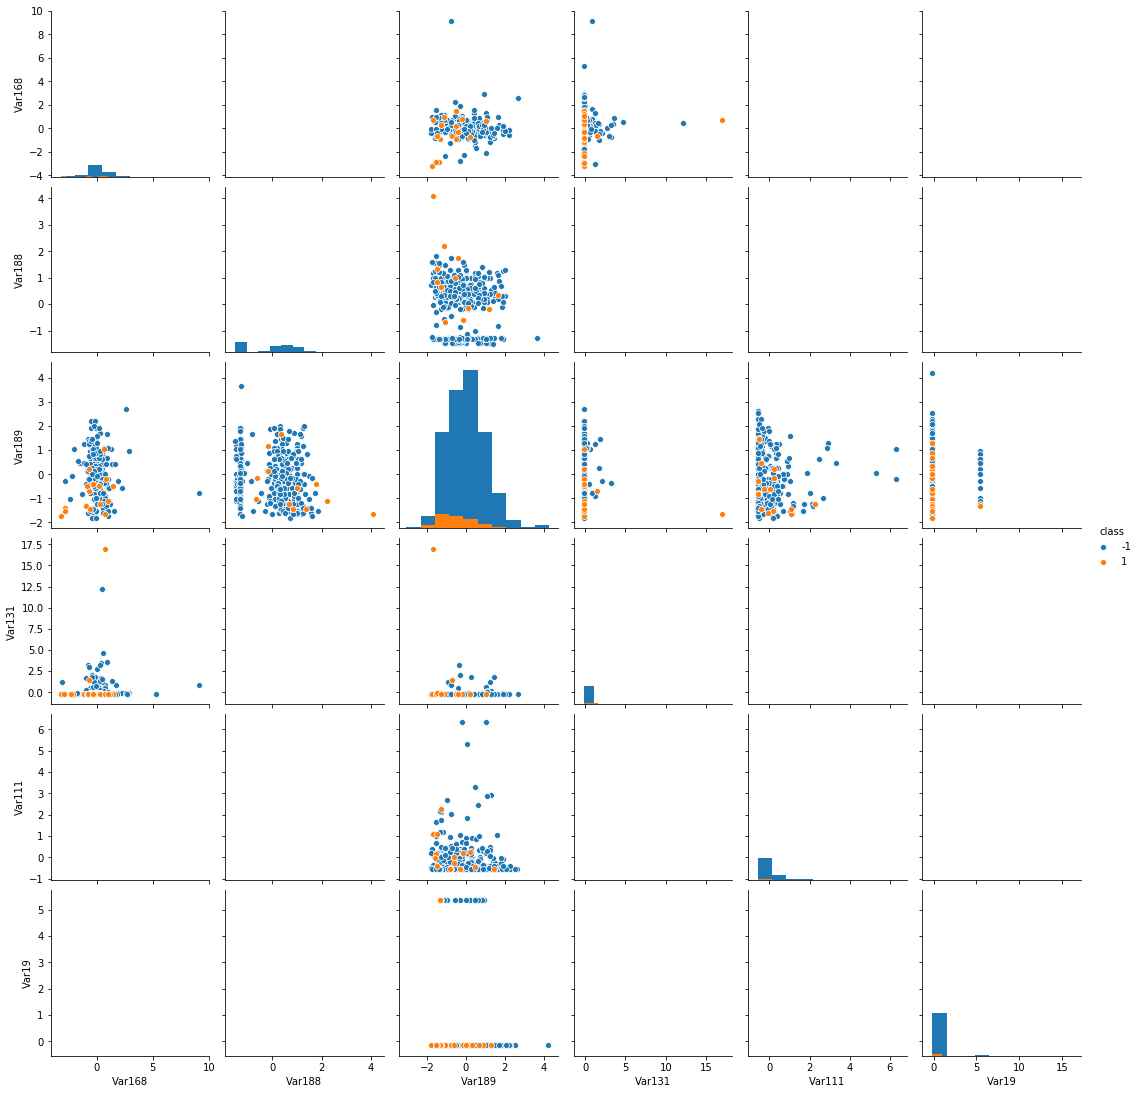

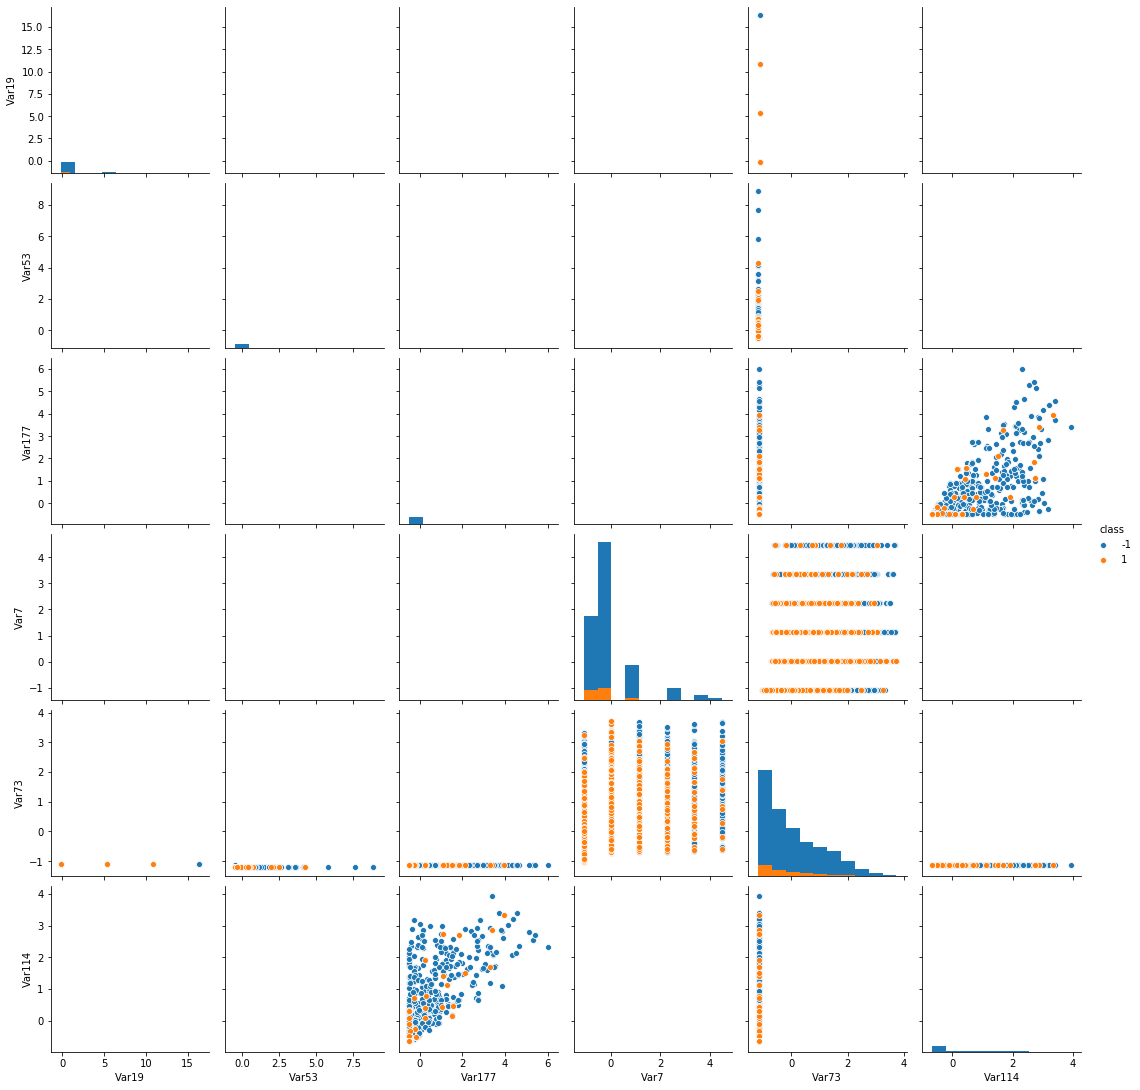

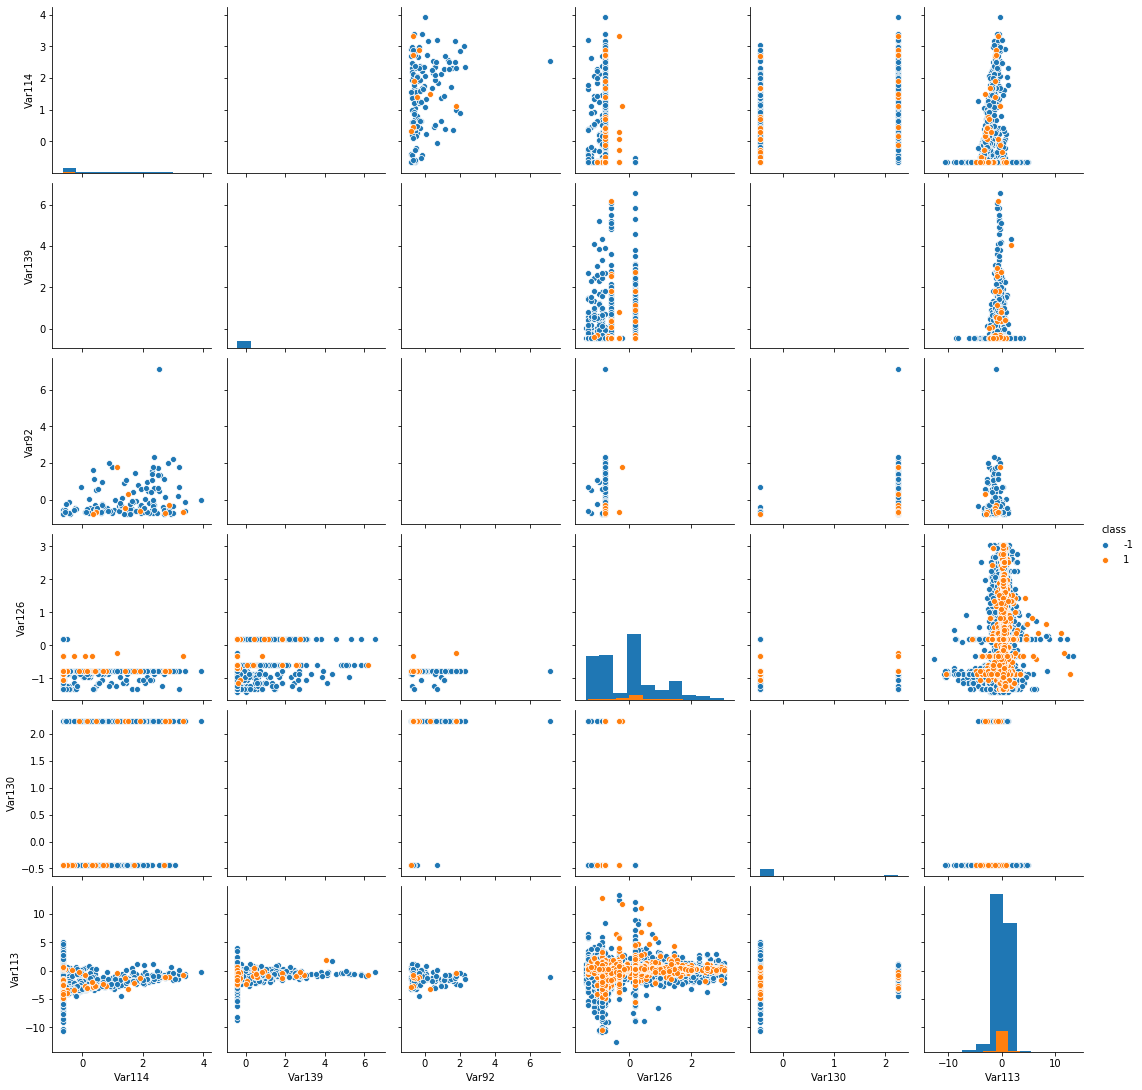

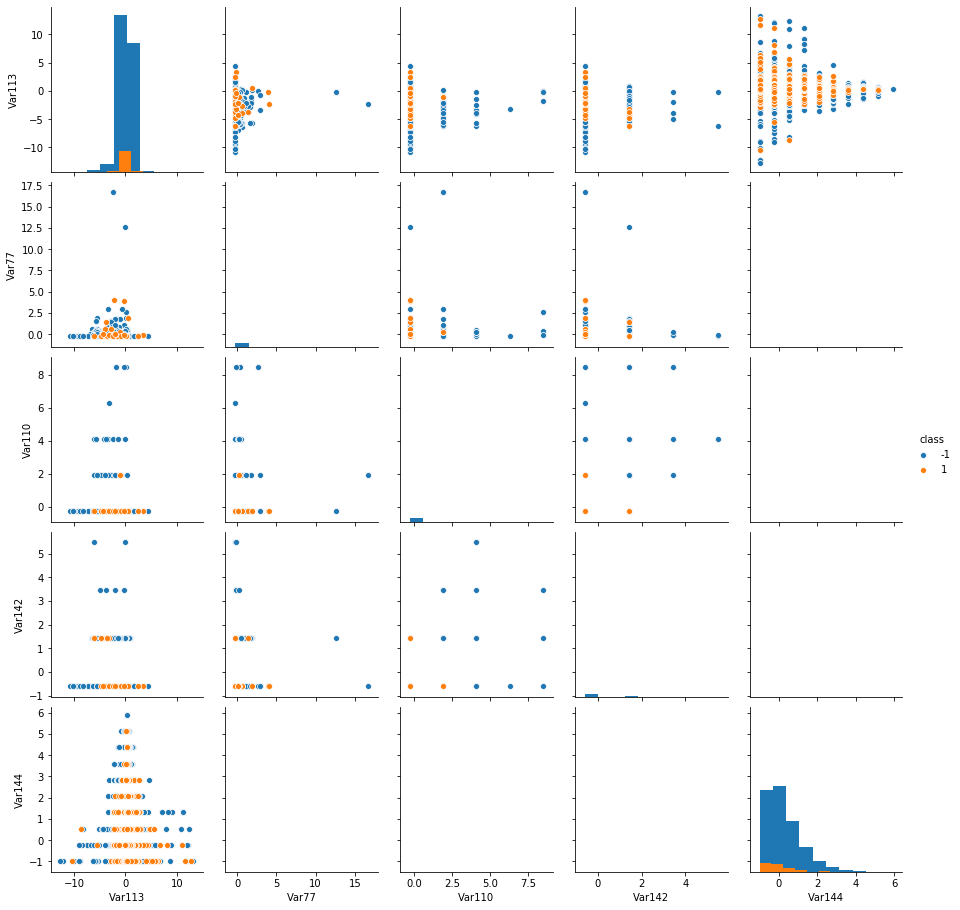

In [39]:
import seaborn as sns
for i in range(5, 21, 5):
    sns.pairplot(scaled_all[list(cor_features)[i-5: i+1 ] + ['class']], diag_kind="hist", hue = 'class')

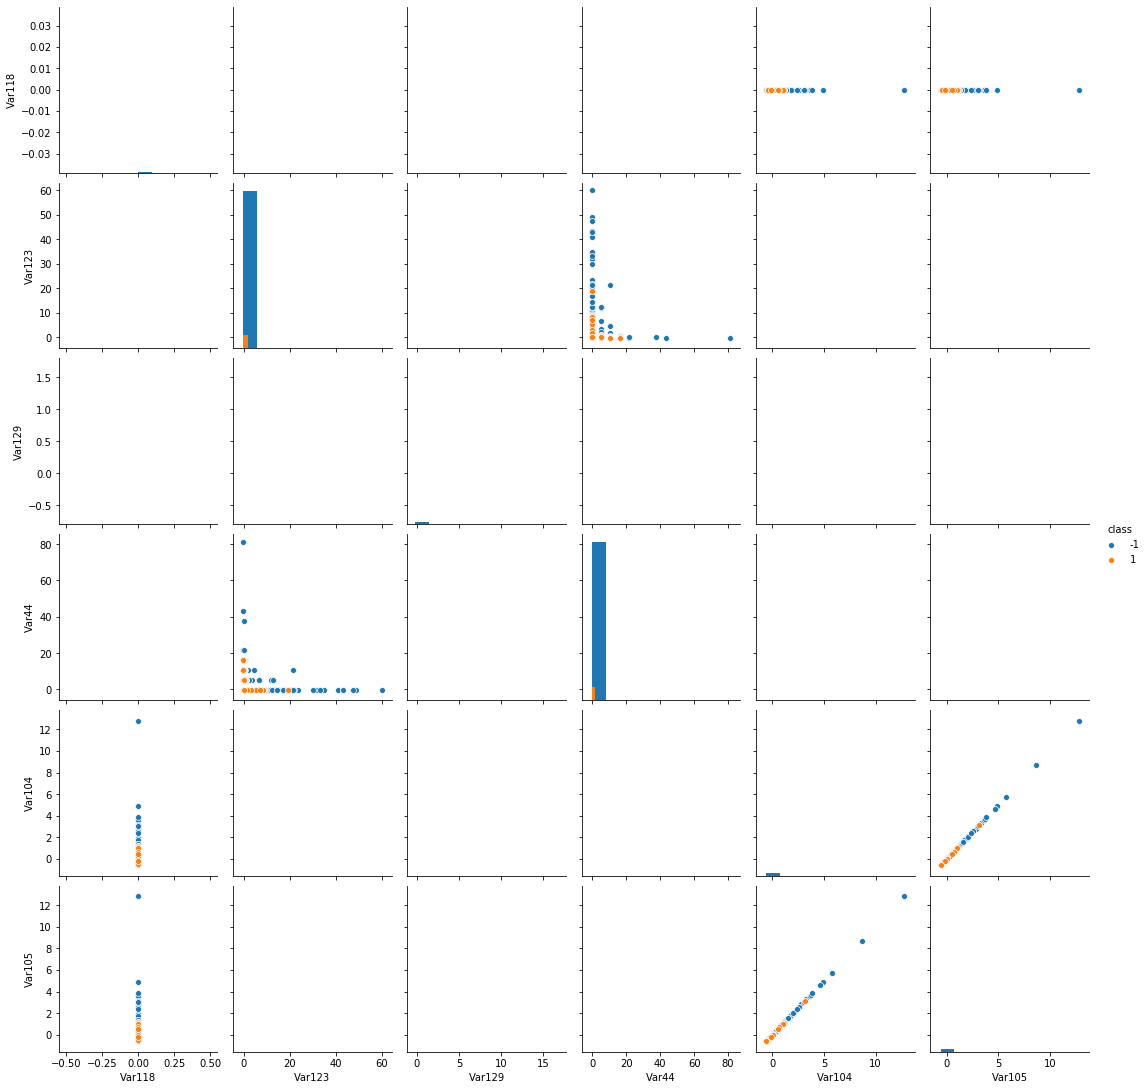

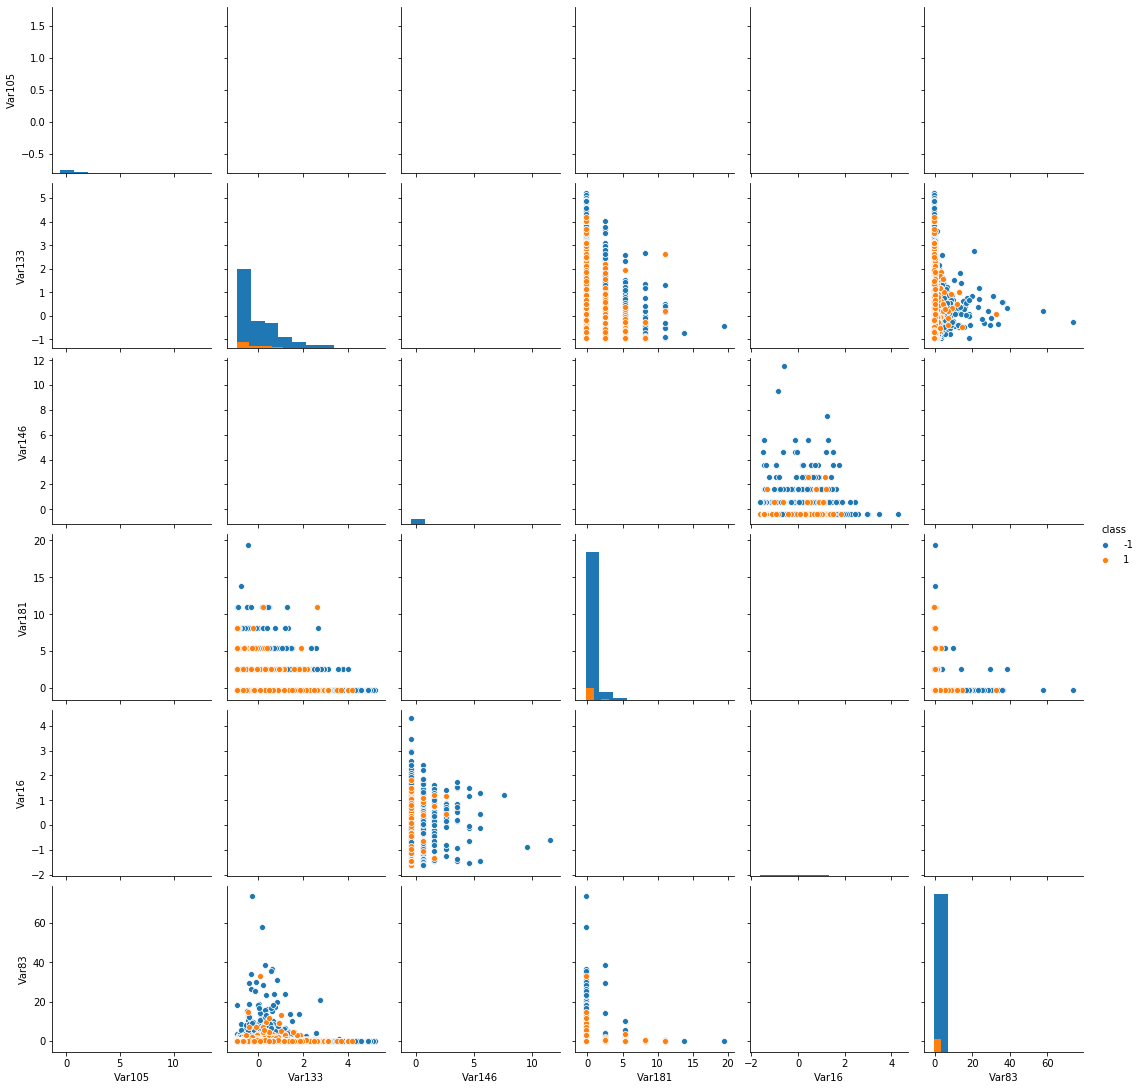

In [40]:
# построим такие же графики для для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной
cor_features = cor_frame.sort_values(by=['abs'], ascending=True).features[:20].values
for i in range(5, 11, 5):
    sns.pairplot(scaled_all[list(cor_features)[i-5: i+1 ] + ['class']], diag_kind="hist", hue = 'class')

Посмотрим на категориальные переменные: построим и сравним гистограммы значений категориальных переменных для разных классов.

In [44]:
len(categorical_features_1)

24

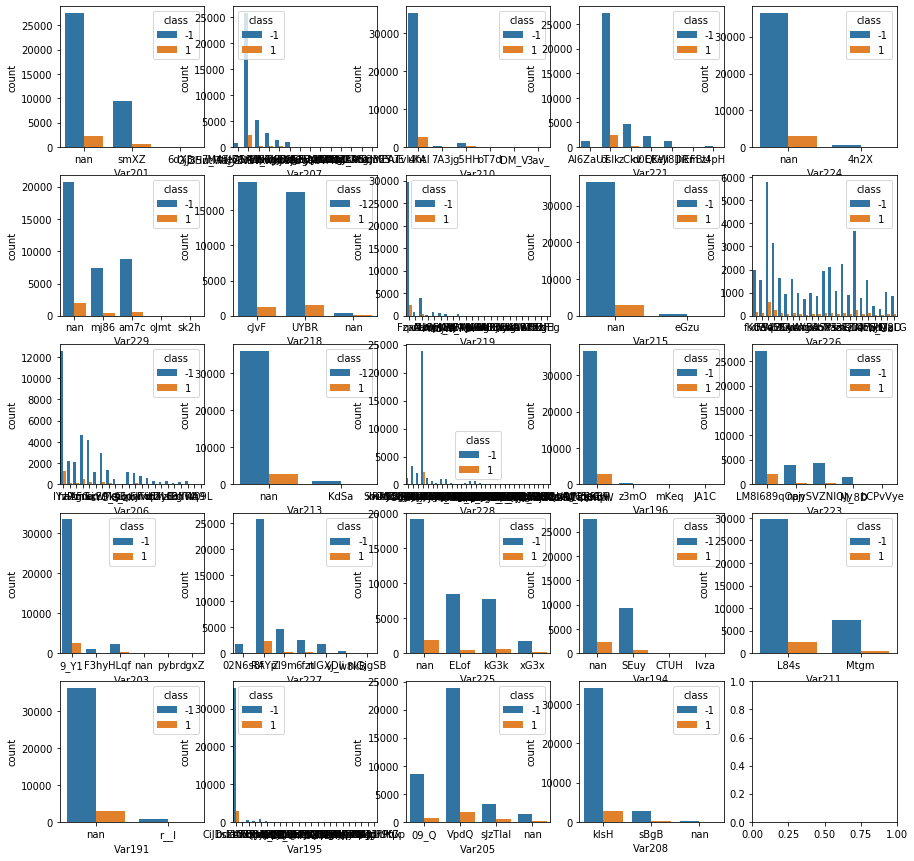

In [46]:
# Использую также библиотеку seaborn. Для визуализации нужен объединенный фрейм (данные + метка)
# строить визуализацию будем только по признакам, у которых уникальных значений меньше 50
df_all = pd.concat([data, labels], axis = 1)
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(5, 5, figsize = (15, 15))
for i in range(len(categorical_features_1)):
    sns.countplot(x = categorical_features_1[i], data = df_all, ax = axes[i//5, i%5], hue = 'class')

- первичный анализ показал, что по данным можно будет построить предсказывающую модель. На 1-м графике(гистограммы зависимостей по числовым признакам, объекты в координатах пар признаков) можно заметить как по некоторым признакам разделяются облако на целевой и нецелевой класс. Различается распределение в зависимости от целевой метки. И чем выше корреляция, тем как правило более видны эти закономерности. Визуализация категориальных признаков показала также, что многие из них могут быть полезны (различаются распределения в зависимости от целевого признака)

Сделаем несколько baseline решений. Возьмем 4 классификатора с параметрами по умолчанию.

И посмотрим как будет меняться качество в зависимости от метода заполнения пропусков, обработки категориальных признаков.

Основная метрика для оценки качества будет AUC ROC – площадь под ROC-кривой. Данная метрика устойчива к дисбалансу класса (что ярко выражено в данной задаче), а также ее преимуществом является инвариантность относительно отношения цены ошибки I и II рода, то есть мы одинаково будем учитывать ошибки как отнесения клиента к классу «отток», так и к классу «не отток». 
Дополнительно будем считать f1, recall, precision

Измерять метрики буду на крос-валидации по 3 фолдам

In [20]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
log_regressor = LogisticRegression(random_state = 1, solver='liblinear')
rf_classifier = RandomForestClassifier(random_state = 1, n_jobs = -1)
xgb_classifier = XGBClassifier(n_jobs = -1, random_state = 1)
cat_classifier = CatBoostClassifier(verbose=False, random_state = 1)

Сделаем функцию, которая на вход будет принимать список из классификаторов, данные, метрики и выдавать сводную таблицу результатов.

In [21]:
from sklearn import model_selection

In [22]:
classifier_list = [(log_regressor, 'log_regressor'), (rf_classifier, 'rf_classifier'), (xgb_classifier, 'xgb_classifier'), (cat_classifier, 'cat_classifier')]
def result_table(classifier_list, data, labels, metrics = ['roc_auc', 'precision', 'recall', 'f1']):
    classifier_metrics = dict()
    for classifier, name_classifier in classifier_list:
        scoring =  model_selection.cross_validate(classifier, data, labels['class'], scoring = metrics, cv = 5)
        classifier_metrics[name_classifier] = [round(scoring['test_roc_auc'].mean(), 3), round(scoring['test_precision'].mean(), 3), round(scoring['test_recall'].mean(), 3), round(scoring['test_f1'].mean(), 3)]
    return(pd.DataFrame(classifier_metrics, index = metrics))

##### 1. Используем данные - количественные признаки как озвучено в задании, пропуски заполняем средним по признаку. Категориальные преобразованы с помощью LabelEncoder  

In [57]:
data_mean = data.copy(deep=True)
data_mean[numeric_features] = data_mean[numeric_features].fillna(data_mean[numeric_features].mean()) 
#Пустые ячейки в категориальных признаках преобразуем в строку 'nan'
data_mean[categorical_features] = data_mean[categorical_features].fillna('nan')

In [70]:
# Преобразуем методом LabelEncoder категориальные признаки
from sklearn.preprocessing import LabelEncoder
for i in data_mean[categorical_features].columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_mean[i])
    data_mean[i] = labelencoder.transform(data_mean[i])

In [78]:
result_table(classifier_list, data_mean[numeric_features + categorical_features], labels[['class']], metrics = ['roc_auc', 'precision', 'recall', 'f1'])

C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

,log_regressor,rf_classifier,xgb_classifier,cat_classifier
roc_auc,0.597,0.666,0.739,0.736
precision,0.145,0.200,0.656,0.667
recall,0.001,0.000,0.007,0.021
f1,0.002,0.001,0.014,0.041


##### 2. Используем данные - количественные признаки как озвучено в задании, пропуски заполняем нулями. Категориальные преобразованы с помощью LabelEncoder  

In [79]:
#Пустые ячейки в числовых признаках заполним нулями
data_zero = data.copy(deep=True)
data_zero.fillna(0,  inplace=True) 

In [80]:
# Преобразуем простым методом(LabelEncoder) категориальные признаки
for i in data_zero[categorical_features].columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_zero[i])
    data_zero[i] = labelencoder.transform(data_zero[i])

In [81]:
# фрейм  с преобразованными данными
zero_labelencoder_data = pd.concat([data_zero[numeric_features], data_zero[categorical_features]], axis = 1)

In [84]:
result_table(classifier_list, zero_labelencoder_data[numeric_features + categorical_features], labels[['class']])

C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

,log_regressor,rf_classifier,xgb_classifier,cat_classifier
roc_auc,0.520,0.67,0.737,0.735
precision,0.225,0.00,0.698,0.709
recall,0.006,0.00,0.006,0.020
f1,0.011,0.00,0.013,0.038


##### 3. Используем первый вариант, но добавим масштабирование количественных признаков

In [85]:
#Пустые ячейки в числовых признаках заполним средним по признаку
data_scaler = data.copy(deep=True)
data_scaler[numeric_features] = data_scaler[numeric_features].fillna(data_scaler[numeric_features].mean()) 
#Пустые ячейки в категориальных признаках преобразуем в строку 'nan'
data_scaler[categorical_features] = data_scaler[categorical_features].fillna('nan')

In [86]:
# Сделаем масштабирование числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_scaler[numeric_features])
scaled_frame = pd.DataFrame(scaler.transform(data_scaler[numeric_features]), columns=numeric_features)

In [87]:
# Преобразуем простым методом(LabelEncoder) категориальные признаки
for i in data_scaler[categorical_features].columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_scaler[i])
    data_scaler[i] = labelencoder.transform(data_scaler[i])

In [88]:
scaler_labelencoder_data = pd.concat([scaled_frame, data_scaler[categorical_features]], axis = 1)

In [89]:
result_table(classifier_list, scaler_labelencoder_data[numeric_features + categorical_features], labels[['class']])

C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

,log_regressor,rf_classifier,xgb_classifier,cat_classifier
roc_auc,0.653,0.667,0.739,0.736
precision,0.117,0.200,0.656,0.667
recall,0.001,0.000,0.007,0.021
f1,0.002,0.001,0.014,0.041


##### 4. Используем третий вариант, но уберем из модели категориальные признаки, у которых уникальных значений более 50

In [98]:
#Пустые ячейки в числовых признаках заполним средним по признаку
data_scaler_2 = data.copy(deep=True)
data_scaler_2[numeric_features] = data_scaler_2[numeric_features].fillna(data_scaler_2[numeric_features].mean()) 
#Пустые ячейки в категориальных признаках преобразуем в строку 'nan'
data_scaler_2[categorical_features_1] = data_scaler_2[categorical_features_1].fillna('nan')

In [99]:
# Сделаем масштабирование числовых признаков
scaler = StandardScaler()
scaler.fit(data_scaler_2[numeric_features])
scaled_frame_2 = pd.DataFrame(scaler.transform(data_scaler_2[numeric_features]), columns=numeric_features)

In [101]:
# Преобразуем простым методом(LabelEncoder) категориальные признаки
for i in data_scaler_2[categorical_features_1].columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_scaler_2[i])
    data_scaler_2[i] = labelencoder.transform(data_scaler_2[i])

In [102]:
scaler_labelencoder_data_2 = pd.concat([scaled_frame_2, data_scaler_2[categorical_features_1]], axis = 1)

In [105]:
result_table(classifier_list, scaler_labelencoder_data_2, labels[['class']])

C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

,log_regressor,rf_classifier,xgb_classifier,cat_classifier
roc_auc,0.656,0.68,0.740,0.737
precision,0.110,0.00,0.742,0.654
recall,0.001,0.00,0.008,0.023
f1,0.003,0.00,0.017,0.043


##### 5. Уберем категориальные признаки с количеством значений больше 50. Категориальные преобразованы с помощью LabelEncoder. Но немного по другому заполним пропуски в числовых переменных - где мало уникальных значений(10 и менее) заполним нульм, остальные средним по признаку.

In [24]:
#Пустые ячейки в числовых признаках заполним средним по признаку
data_scaler_3 = data.copy(deep=True)
data_scaler_3[numeric_features_2] = data_scaler_3[numeric_features_2].fillna(data_scaler_3[numeric_features_2].mean()) 
data_scaler_3[false_numeric_features] = data_scaler_3[false_numeric_features].fillna(0) 

#Пустые ячейки в категориальных признаках преобразуем в строку 'nan'
data_scaler_3[categorical_features_1] = data_scaler_3[categorical_features_1].fillna('nan')

In [25]:
# Сделаем масштабирование числовых признаков
scaler = StandardScaler()
scaler.fit(data_scaler_3[numeric_features])
scaled_frame_3 = pd.DataFrame(scaler.transform(data_scaler_3[numeric_features]), columns=numeric_features)

In [27]:
# Преобразуем простым методом(LabelEncoder) категориальные признаки
from sklearn.preprocessing import LabelEncoder
for i in data_scaler_3[categorical_features_1].columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_scaler_3[i])
    data_scaler_3[i] = labelencoder.transform(data_scaler_3[i])

In [28]:
scaler_labelencoder_data_3 = pd.concat([scaled_frame_3, data_scaler_3[categorical_features_1]], axis = 1)

In [29]:
result_table(classifier_list, scaler_labelencoder_data_3, labels[['class']])

C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,log_regressor,rf_classifier,xgb_classifier,cat_classifier
roc_auc,0.657,0.681,0.740,0.736
precision,0.074,0.200,0.709,0.626
recall,0.001,0.000,0.008,0.020
f1,0.002,0.001,0.015,0.040


Пока что это самая удачная версия - убираем из данных категориальные признаки, у которых количество уникальных значений более 50, заполняем пропуски в числовых переменных нулями, любо средними, делаем масштабирование. Категориальные преобразовываем с помощью LabelEncoder.

Можно попробовать обработать категориальные признаки методом OneHotEncoder, он, скорее всего улучшит качество на логистической регрессии. Но в данной задаче у нас  в фаворитах методы градиентного бустинга, для них эта процедура не к чему, а для Катбуста вообще противопоказана(OneHotEncoder нужно напрямую указыать при обучении, заранее предобрабатывать крайне не рекомендуется)

Выборка сильно не сбалансирована. Попробую поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

In [114]:
# Для удобства признаки и таргет объединим в один датафрейм. Использовать будем все доступные данные.
df_all = pd.concat([scaler_labelencoder_data_3, labels], axis = 1)

In [115]:
# посмотрим на соотношение классов
print('Количество объектов с классом 1 - ', sum(df_all['class'] == 1))
print('Количество объектов с классом -1 - ', sum(df_all['class'] == -1))

Количество объектов с классом 1 -  2976
Количество объектов с классом -1 -  37024


Целевой класс(отток) более чем в 12 раз меньше класса "-1"

Буду задавать веса классам через параметры основных моделей - логистической регрессии, случайного леса, катбуста. Сделаю функцию, на вход которой подаются данные, таргет и список весов для 1-го класса (которого у нас значительно меньше в выборке).

Результатом функции будет сравнительная таблица.

In [118]:
def result_table(data, weights = [1, 0.5, 3, 5]):
    weights_balance = dict()
    for weight in weights:
        classifier_list = [(LogisticRegression(random_state = 1, solver='liblinear', class_weight = {1 : weight, -1 : 1})),
                          (RandomForestClassifier(random_state = 1, n_jobs = -1, class_weight = {1 : weight, -1 : 1})),
                           (CatBoostClassifier(verbose=False, random_state = 1,  scale_pos_weight = weight))
                          ]
        metrics = []
        for classifier in classifier_list:
            classifier = classifier
            scoring =  model_selection.cross_val_score(classifier, data.loc[:, 'Var1': 'Var205'], data['class'], scoring = 'roc_auc', cv = 3)
            metrics.append(round(scoring.mean(), 3))
        weights_balance[weight] = metrics
    return(pd.DataFrame(weights_balance, index = ['log_regressor', 'rf_classifier', 'cat_classifier']))

In [117]:
result_table(df_all, weights = [1, 0.2, 0.5, 3, 5, 10])

,1.0,0.2,0.5,3.0,5.0,10.0
log_regressor,0.656,0.656,0.656,0.655,0.654,0.653
rf_classifier,0.668,0.670,0.678,0.675,0.683,0.684
cat_classifier,0.736,0.739,0.738,0.726,0.719,0.715


Ожидаемые результаты получились только по Случайному лесу, с увеличением веса 1-го класса улучшается качество, 1 : 10 - оптимальный вариант.

По Логистической регрессии качество почте не меняется при изменении веса 1-го класса.

Странно повел себя катбуст. При снижении веса 1-го класса качество повышается, при увеличении наоборот падает.

Применю к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось.

Сделаю функцию, которая на вход принимает датафрейм и список из размеров undersampling. И будет выдавать таблицу результатов.

In [119]:
log_regressor = LogisticRegression(random_state = 1, solver='liblinear')
rf_classifier = RandomForestClassifier(random_state = 1, n_jobs = -1)
xgb_classifier = XGBClassifier(n_jobs = -1, random_state = 1)
cat_classifier = CatBoostClassifier(verbose=False, random_state = 1)

In [120]:
classifier_list = [log_regressor, rf_classifier, xgb_classifier, cat_classifier,]
def result_table_undersampled(data, sizes = [3000, 6000, 10000]):
    size_undersampled = dict()
    for size in sizes:
        undersampled_data = pd.concat([ data[data['class']==-1].sample(size) , data[data['class']==1] ])
        metrics = []
        for classifier in classifier_list:
            classifier = classifier
            scoring =  model_selection.cross_val_score(classifier, undersampled_data.loc[:, 'Var1': 'Var205'], undersampled_data['class'], scoring = 'roc_auc', cv = 3)
            metrics.append(round(scoring.mean(), 3))
        size_undersampled[size] = metrics
    return(pd.DataFrame(size_undersampled, index = ['log_regressor', 'rf_classifier', 'xgb_classifier', 'cat_classifier']))

In [121]:
result_table_undersampled(df_all, sizes = [37024, 3000, 6000, 10000, 15000, 20000])

,37024,3000,6000,10000,15000,20000
log_regressor,0.655,0.647,0.648,0.646,0.653,0.658
rf_classifier,0.672,0.702,0.694,0.687,0.686,0.685
xgb_classifier,0.737,0.736,0.735,0.733,0.737,0.737
cat_classifier,0.735,0.730,0.733,0.732,0.733,0.734


- log_regressor - наилучшие результаты либо без андерсэмплинга, либо при размере 20 000
- случайный лес - лучший результат 6 000
- xgb_classifier - Наилучшие результаты либо без андерсэмплинга, либо при размере 15 000
- катбуст - без андерсэмплинга

Возможно такой подход несовсем верный - я делаю андерсэмплинг и потом на этих же данных делаю крос валидацию. Разделю данные на тестовую и обучающую выборку, на обучающей сделаю андерсэмплинг, на тесте сравню метрику

In [122]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(df_all.loc[:, 'Var1': 'Var205'], df_all['class'], test_size = 0.2, stratify=df_all['class'], random_state = 1)

In [123]:
train_data_all = pd.concat([train_data, train_labels], axis = 1)

In [124]:
from sklearn.metrics import roc_auc_score

In [125]:
from sklearn.metrics import roc_auc_score
def result_table_undersampled(train_data_all, test_data, test_labels, sizes = [3000, 6000, 10000]):
    size_undersampled = dict()
    for size in sizes:
        undersampled_data = pd.concat([ train_data_all[train_data_all['class']==-1].sample(size), 
                                       train_data_all[train_data_all['class']==1] ])
        metrics = []
        for classifier in classifier_list:
            classifier = classifier
            classifier.fit(undersampled_data.loc[:, 'Var1': 'Var205'], undersampled_data['class'])
            predictions = classifier.predict_proba(test_data)[:,1]
            scoring = roc_auc_score(test_labels, predictions)
            metrics.append(round(scoring.mean(), 3))
        size_undersampled[size] = metrics
    return(pd.DataFrame(size_undersampled, index = ['log_regressor', 'rf_classifier', 'xgb_classifier', 'cat_classifier']))

In [126]:
result_table_undersampled(train_data_all, test_data, test_labels, sizes = [29619, 3000, 6000, 10000, 15000, 20000])

,29619,3000,6000,10000,15000,20000
log_regressor,0.652,0.639,0.648,0.648,0.647,0.653
rf_classifier,0.669,0.694,0.695,0.684,0.686,0.671
xgb_classifier,0.738,0.733,0.734,0.738,0.735,0.736
cat_classifier,0.732,0.725,0.734,0.736,0.739,0.734


- log_regressor - наилучшие результаты либо без андерсэмплинга, либо при размере 20 000
- случайный лес - 6 000
- xgb_classifier - Наилучшие результаты либо без андерсэмплинга, либо при размере 10 000
- катбуст - 15 000 

Вообще значимо метрика улучшается у случайного леса, у др классификаторов отличия минимальны

Оверсэмплинг со SMOTE:

In [127]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_sm, y_sm = smote.fit_sample(train_data, train_labels)

In [128]:
def result_table_smote(train_data, train_labels, test_data, test_labels):
    smote_undersampled = dict()
    metrics = []
    for classifier in classifier_list:
        classifier = classifier
        classifier.fit(train_data, train_labels)
        predictions = classifier.predict_proba(test_data)[:,1]
        scoring = roc_auc_score(test_labels, predictions)
        metrics.append(round(scoring.mean(), 3))
    smote_undersampled['smote'] = metrics
    return(pd.DataFrame(smote_undersampled, index = ['log_regressor', 'rf_classifier', 'xgb_classifier', 'cat_classifier']))

In [129]:
result_table_smote(X_sm, y_sm, test_data, test_labels)

C:\Users\IlyaS\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,smote
log_regressor,0.605
rf_classifier,0.651
xgb_classifier,0.671
cat_classifier,0.709


У всех классификаторов качество снизилось

Андерсэмплинг с использованием Tomek Links:

In [131]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_tl, y_tl = tl.fit_sample(train_data, train_labels)

In [132]:
result_table_smote(X_tl, y_tl, test_data, test_labels)

,smote
log_regressor,0.651
rf_classifier,0.674
xgb_classifier,0.739
cat_classifier,0.734


Оценки практически такие же как и без какой-либо предобработки

Возьму лучшие модели - XGBClassifier и CatBoostClassifier, подберу для них гиперпараметры, обучу на всех доступных данных.
После этого получу предсказания для конкурса и проверяю на сайте(Leaderboard)

Сначала проделаю все те же действия для тестовой выборки.

In [30]:
# загружаем данные
test_data = pd.read_csv('orange_small_churn_test_data.csv')

In [31]:
# оставляем только нужные столбцы
test_data = test_data[list(numeric_features) + list(categorical_features_1)]

In [32]:
# заполняю пропуски в числовых переменных
test_data[numeric_features_2] = test_data[numeric_features_2].fillna(test_data[numeric_features_2].mean()) 
test_data[false_numeric_features] = test_data[false_numeric_features].fillna(0) 

#Пустые ячейки в категориальных признаках преобразуем в строку 'nan'
test_data[categorical_features_1] = test_data[categorical_features_1].fillna('nan')
# делаем масштабирование
test_scaled_data = pd.DataFrame(scaler.transform(test_data[numeric_features]), columns = numeric_features)

In [33]:
# преобразуем категориальные признаки
data_scaler_2 = data.copy(deep=True)
data_scaler_2[categorical_features_1] = data_scaler_2[categorical_features_1].fillna('nan')
for i in data_scaler_2[categorical_features_1].columns:
    labelencoder = LabelEncoder()
    labelencoder.fit(data_scaler_2[i]) # обучаем на тренеровочной выборке
    test_data[i] = labelencoder.transform(test_data[i]) # применяем к тестовой

In [34]:
# преобразованные данные
test_scaled_data_all = pd.concat([test_scaled_data, test_data[categorical_features_1]], axis = 1)

1. #### XGBClassifier. 

In [158]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(n_jobs = -1, random_state = 1)

In [159]:
parameters_grid = {
    'learning_rate' : [0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [4, 5, 6],
    }

In [160]:
grid_cv = model_selection.GridSearchCV(xgb_classifier, parameters_grid, scoring = 'roc_auc', cv = 3)
grid_cv.fit(scaler_labelencoder_data_3, labels['class'])

GridSearchCV(cv=3, estimator=XGBClassifier(n_jobs=-1, random_state=1),
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 3, 4],
                         'min_child_weight': [4, 5, 6]},
             scoring='roc_auc')

In [161]:
grid_cv.best_estimator_

XGBClassifier(max_depth=2, min_child_weight=5, n_jobs=-1, random_state=1)

In [162]:
grid_cv.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5}

In [163]:
grid_cv.best_score_

0.7388648545582209

In [166]:
# обучаю с наилучшими праметрами и проверяю на сайте(Leaderboard)
classifier_xgb_all = XGBClassifier(learning_rate = 0.1, max_depth = 2, min_child_weight=5, n_jobs=-1, random_state=1)
classifier_xgb_all.fit(scaler_labelencoder_data_3, labels['class'])
xgb_test_2 = pd.DataFrame({'Id' : range(10000), 'result' : classifier_xgb_all.predict_proba(test_scaled_data_all)[:,1]})
xgb_test_2.to_csv('xgb_test_2_1.csv', index=False)
# результат на сайте конкурса 0.70735

2. #### CatBoostClassifier. 

In [35]:
cat_classifier = CatBoostClassifier(verbose=False, random_state = 1)

In [36]:
cat_features = list(range(len(numeric_features), len(numeric_features) + len(categorical_features_1)))

In [38]:
from catboost.utils import create_cd
feature_names = dict()
for column, name in enumerate(scaler_labelencoder_data_3):
    feature_names[column] = name
    
create_cd(
    cat_features=cat_features,
    feature_names=feature_names
)

In [39]:
from catboost import Pool

In [171]:
# Подбираю "learning_rate" и "iterations"
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 1100
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.02

cv_data = cv(
    params = params,
    pool = Pool(scaler_labelencoder_data_3, label=labels['class'], cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False,
    early_stopping_rounds=20,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)


In [172]:
best_value = np.max(cv_data['test-AUC-mean'])
best_iter = np.argmax(cv_data['test-AUC-mean'])

print('Best validation AUC score: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation AUC score: 0.7439±0.0029 on step 827


In [60]:
cat_classifier = CatBoostClassifier(
    iterations=850,
    learning_rate=0.02,
    verbose=False)

In [61]:
# Подбираю остальные параметры по сетке
parameters_grid = {
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 6],
    'one_hot_max_size' : [2, 10],
    'random_strength' : [3, 63]
    }

In [62]:
grid_cv = model_selection.GridSearchCV(cat_classifier, parameters_grid, scoring = 'roc_auc', cv = 3)
grid_cv.fit(scaler_labelencoder_data_3, labels['class'])

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E6A787F4C8>,
             param_grid={'depth': [4, 6, 8], 'l2_leaf_reg': [3, 6],
                         'one_hot_max_size': [2, 10],
                         'random_strength': [3, 63]},
             scoring='roc_auc')

In [63]:
grid_cv.best_estimator_.get_params()

{'iterations': 850,
 'learning_rate': 0.02,
 'depth': 6,
 'l2_leaf_reg': 3,
 'verbose': False,
 'one_hot_max_size': 2,
 'random_strength': 3}

In [177]:
grid_cv.best_score_

0.7413094007600418

In [178]:
grid_cv.best_params_

{'depth': 6, 'l2_leaf_reg': 3, 'one_hot_max_size': 2, 'random_strength': 3}

In [57]:
# обучаю с подобранными параметрами
classifier_cat_all = CatBoostClassifier(verbose=False, iterations = 800, random_seed = 3,
                                        learning_rate = 0.02, depth = 6, one_hot_max_size = 2,
                                        random_strength = 3, l2_leaf_reg = 3)
classifier_cat_all.fit(scaler_labelencoder_data_3, labels['class'])

In [58]:
# Проверяю на Leaderboard
cat_test_3 = pd.DataFrame({'Id' : range(10000), 'result' : classifier_cat_all.predict_proba(test_scaled_data_all)[:,1]})
cat_test_3.to_csv('cat_test_3_1_1.csv', index=False)
#результат на сайте конкурса 0.71301

In [193]:
# Попробую поэкспериментировать с параметрами установлю параметры, которые должны повысить качество
classifier_cat_all = CatBoostClassifier(verbose=False, iterations = 800, random_seed = 3,
                                        learning_rate = 0.02, boosting_type = 'Ordered', one_hot_max_size = 2,
                                        leaf_estimation_method = 'Newton')
classifier_cat_all.fit(scaler_labelencoder_data_2, labels['class'])

In [194]:
cat_test_2 = pd.DataFrame({'Id' : range(10000), 'result' : classifier_cat_all.predict_proba(test_scaled_data_all)[:,1]})
cat_test_2.to_csv('cat_test_2_1_1.csv', index=False)
#результат на сайте конкурса 0.71404

После подбора гиперпараметров катбуст оказался лучшим

Посмотрим, какие признаки внесли наибольший вклад в модель.

In [195]:
classifier_cat_all.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,Var126,34.774756
1,Var73,5.712953
2,Var189,5.683676
3,Var218,5.178571
4,Var113,3.520584
5,Var81,3.101316
6,Var210,2.553916
7,Var74,2.538881
8,Var13,2.365752
9,Var205,1.919374


На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности?

In [65]:
# для удобства заменю метку -1 на 0
labels[labels['class'] == -1] = 0

In [66]:
# разделяю выборку
train_data, hold_out_data, train_labels, hold_out_labels = model_selection.train_test_split(scaler_labelencoder_data_3,
                                                           labels, test_size = 0.2, stratify=labels, random_state = 1)

In [67]:
# обучаю классификатор на трейне
classifier_cat = CatBoostClassifier(verbose=False, iterations = 850, random_seed = 3,
                                        learning_rate = 0.02, boosting_type = 'Ordered', one_hot_max_size = 2,
                                        leaf_estimation_method = 'Newton')
classifier_cat.fit(train_data, train_labels['class'], cat_features=cat_features)

In [68]:
# получаю предсказания на тесте
predictions = classifier_cat.predict_proba(hold_out_data)[:,1]

In [69]:
# считаю ошибку и оформляю все это в дата фрейм
mistake = pd.DataFrame({'True_labels' : hold_out_labels['class'], 'predictions' : predictions})
mistake['mistake'] = abs(mistake.True_labels - mistake.predictions)
mistake = mistake.sort_values(by=['mistake'], ascending=False)
mistake.head(10)

,True_labels,predictions,mistake
24234,1,0.006543,0.993457
3224,1,0.010876,0.989124
15142,1,0.011679,0.988321
35229,1,0.013695,0.986305
2040,1,0.015047,0.984953
8067,1,0.015091,0.984909
2622,1,0.016441,0.983559
1747,1,0.016582,0.983418
18593,1,0.018752,0.981248
30630,1,0.019452,0.980548


In [70]:
# строки с наибольшей ошибкой
index_mistake = mistake.head(10).index
index_mistake

Int64Index([24234, 3224, 15142, 35229, 2040, 8067, 2622, 1747, 18593, 30630], dtype='int64')

In [71]:
# чтобы отображались все столбцы
pd.set_option('display.max_columns', None)

In [72]:
# выделим объекты с наибольшей ошибкой
data.loc[index_mistake, :]

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,Var12,Var13,Var14,Var16,Var17,Var18,Var19,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var33,Var34,Var35,Var36,Var37,Var38,Var40,Var41,Var43,Var44,Var45,Var46,Var47,Var49,Var50,Var51,Var53,Var54,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var168,Var170,Var171,Var172,Var173,Var174,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
24234,NaN,NaN,NaN,NaN,NaN,637.0,7.0,NaN,NaN,NaN,NaN,10292.0,NaN,NaN,NaN,NaN,NaN,284.0,355.0,NaN,2.0,72.0,NaN,NaN,245.68,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3820626.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.453749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,264,399.0,NaN,1908632.0,NaN,0.0,NaN,204955.80,NaN,35.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37785.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,NaN,NaN,40.0,-296489.6,NaN,NaN,NaN,NaN,NaN,580.0,NaN,NaN,NaN,186.0,NaN,2295.0,-20.0,NaN,NaN,NaN,NaN,NaN,0.0,4080875.0,830228.0,NaN,NaN,NaN,NaN,NaN,565.0,NaN,0.0,54.0,NaN,NaN,NaN,NaN,118167.0,NaN,NaN,NaN,10386520.0,NaN,NaN,NaN,NaN,NaN,NaN,34.0,NaN,NaN,384960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,366.0,NaN,NaN,8Fdr4RXXnK,BrRu5UxtiQY9TTJ8ABKpfS,SEuy,taul,1K8T,lK27,fhk21Ss,Pkku4gO,hL8e37S,smXZ,S0AX,9_Y1,5euo,VpdQ,y6dw,7M47J5GA0pTYIFxg5uy,kIsH,uKAI,Mtgm,MeOIHRG3F9,NaN,tV_fB_k,NaN,11pFugQ,qZh0,UYBR,AU8pNoi,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,xG3x,7FJQ,ZI9m,VjDE,mj86
3224,NaN,NaN,NaN,NaN,NaN,1750.0,7.0,NaN,NaN,NaN,NaN,228.0,NaN,NaN,NaN,NaN,NaN,24.0,30.0,NaN,0.0,8.0,NaN,NaN,271.20,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5524338.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,38493.36,NaN,NaN,NaN,2.964110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,160,63.0,NaN,0.0,NaN,0.0,NaN,20975.91,NaN,10.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,0.0,51163.2,NaN,NaN,NaN,NaN,NaN,575.0,NaN,NaN,NaN,12.0,NaN,18621.0,-26.0,NaN,NaN,NaN,NaN,NaN,0.0,1436975.0,1209600.0,NaN,NaN,NaN,NaN,NaN,490.0,NaN,0.0,18.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,9593880.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dTGmfo8zhV,g62hiBSaKg,NaN,taul,1K8T,0Xwj,fhk21Ss,MypvvoIQqc,DlI8rQZ,NaN,NT2l,HLqf,6Kw9,09_Q,haYg,7M47J5GA0pTYIFxg5uy,sBgB,uKAI,L84s,4kVnq_T26xq1p,NaN,dzmQK5c,NaN,pMWTdyD,PezG,cJvF,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,ELof,3Cy4,ZI9m,ib5G6X1eUxUn6,am7c
15142,NaN,NaN,NaN,NaN,NaN,875.0,14.0,NaN,NaN,NaN,NaN,1744.0,NaN,NaN,NaN,NaN,NaN,136.0,170.0,NaN,2.0,112.0,NaN,NaN,270.08,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1662966.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.168554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,50,56.0,NaN,1453432.0,NaN,9.0,NaN,206724.30,NaN,10.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN,NaN,32.0,53292.4,NaN,NaN,NaN,NaN,NaN,555.0,NaN,NaN,NaN,24.0,NaN,47781.0,-3

Можно предположить, наибольшая ошибка получается на объектах, на которых изначально было много пропусков.

Для наглядности построю ROC кривую

In [212]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

In [213]:
eval_pool = Pool(hold_out_data,  hold_out_labels, cat_features=cat_features)
curve = get_roc_curve(classifier_cat, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

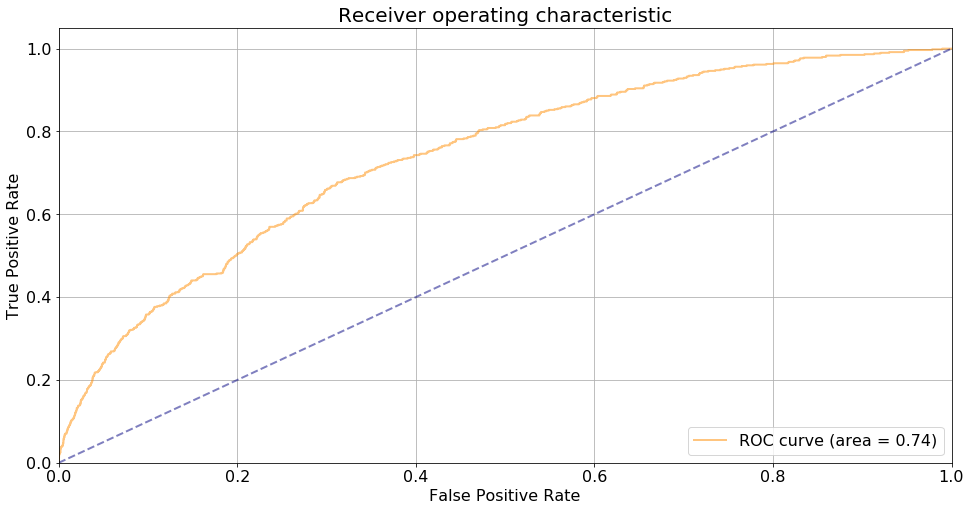

In [214]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Но более наглядным и полезным для целей бизнеса, возможно, будет график precision_recall_curve. 

In [215]:
from sklearn.metrics import precision_recall_curve
predicted = classifier_cat.predict_proba(hold_out_data)[:,1]
prec, rec, thresh = precision_recall_curve(hold_out_labels, predicted)

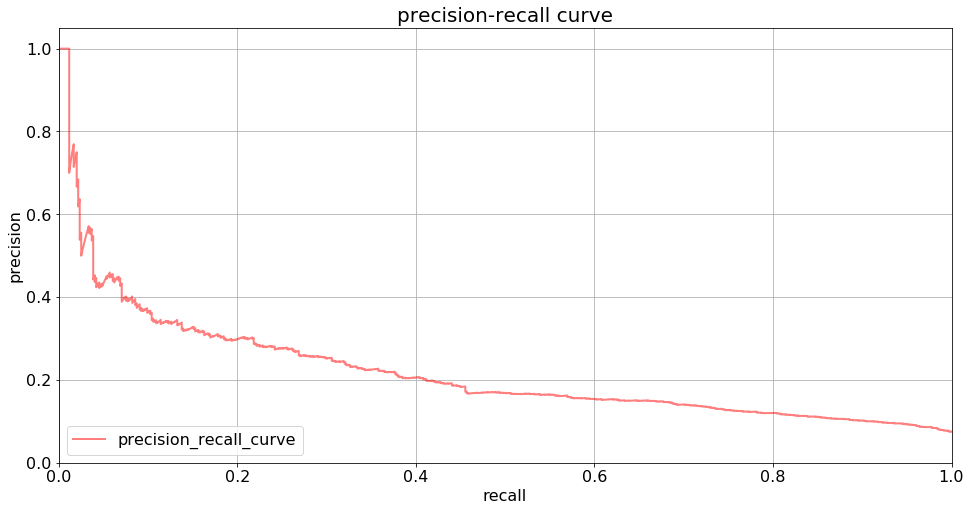

In [216]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(rec, prec, color='r', lw=lw, label='precision_recall_curve', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('recall', fontsize=16)
plt.ylabel('precision', fontsize=16)
plt.title('precision-recall curve', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

По оси Х отмечена полнота, по оси Y  - точность, а линия – это пороги отнесения пользователей к классу «отток» от большего к меньшему. Данный график поможет визуально выбрать необходимый порог отнесения объекта к классу «отток». То есть если нам в 1-ю очередь важна точность (насколько полно мы определим всех клиентов, склонных к оттоку при этом на 2-м месте), то мы выбираем  порог ближе к началу координат. Если же для компании первоочередной задачей является по максимуму выявить всех пользователей, собирающихся уйти и при этом не так важно, что к этой категории по ошибки будут отнесены лояльные клиенты, то выбираем маленький порог (правее). Полнота при этом высокая, но точность минимальная.
Исходя из приоритетов бизнеса, стоимости кампании по удержанию клиента можно выбрать оптимальный порог отнесения клиента к целевому классу. Как вариант компания может выбрать низкий порог, максимально охватив всех «недовольных» клиентов, но при этом предложить акцию/скидку только для пользователей, от которых максимальная выручка. Либо можно перед объявлением акции обзвонить клиентов(сделать онлайн опрос) и после этого принять решение о том стоит ли включать этого клиента в кампанию по удержанию. В любом случае использование результатов прогнозирования дает возможность улучшить экономические показатели.
